In [1]:
import numpy as np
import pandas as pd

import scipy.stats as ss


from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
import catboost as catb
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pprint import pprint

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Построение модели классификации

### 1. Обзор обучающего датасета


#### Описание датасета

* Home Ownership - домовладение
* Annual Income - годовой доход
* Years in current job - количество лет на текущем месте работы
* Tax Liens - налоговые обременения
* Number of Open Accounts - количество открытых счетов
* Years of Credit History - количество лет кредитной истории
* Maximum Open Credit - наибольший открытый кредит
* Number of Credit Problems - количество проблем с кредитом
* Months since last delinquent - количество месяцев с последней просрочки платежа
* Bankruptcies - банкротства
* Purpose - цель кредита
* Term - срок кредита
* Current Loan Amount - текущая сумма кредита
* Current Credit Balance - текущий кредитный баланс
* Monthly Debt - ежемесячный долг
* Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

#### Пути к директориям и файлам

In [3]:
PATH = 'C:/Users/ASER/Desktop/GeekBrains/ML_project/'
TRAIN_DATASET_PATH = PATH + 'course_project_train.csv'
TEST_DATASET_PATH = PATH + 'course_project_test.csv'
PREP_DATASET_PATH = PATH + 'course_project_prep_train.csv'

### 2. Загрузка данных

In [4]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head(2)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1


In [5]:
X_final = pd.read_csv(TEST_DATASET_PATH)
print('X_final.shape', X_final.shape)
X_final.head(2)

X_final.shape (2500, 16)


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0


In [6]:
TARGET_NAME = 'Credit Default'
X = df.drop(TARGET_NAME, axis=1)
y = df[TARGET_NAME]
print('X.shape = ', X.shape)
print('y.shape = ', y.shape)

X.shape =  (7500, 16)
y.shape =  (7500,)


In [7]:
NUMERIC_FEATURE_NAMES = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History',
                         'Maximum Open Credit', 'Number of Credit Problems', 
                         'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount',
                         'Current Credit Balance', 'Monthly Debt', 'Credit Score']

CATEGORICAL_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Tax Liens', 'Purpose', 'Term']

### 3. Анализ целевой переменной

### 3.1 Обзор распределения

In [8]:
y.value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

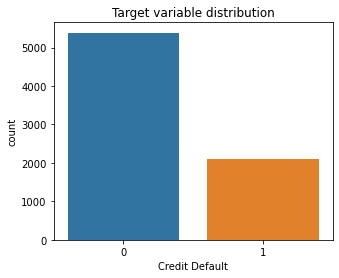

In [9]:
plt.figure(figsize=(5, 4))

sns.countplot(x=TARGET_NAME, data=df)

plt.title('Target variable distribution')
plt.show()

### 3.2 Оценка признаков в в разрезе целевой переменной

#### A. Числовые признаки

**Корреляция с базовыми признаками**

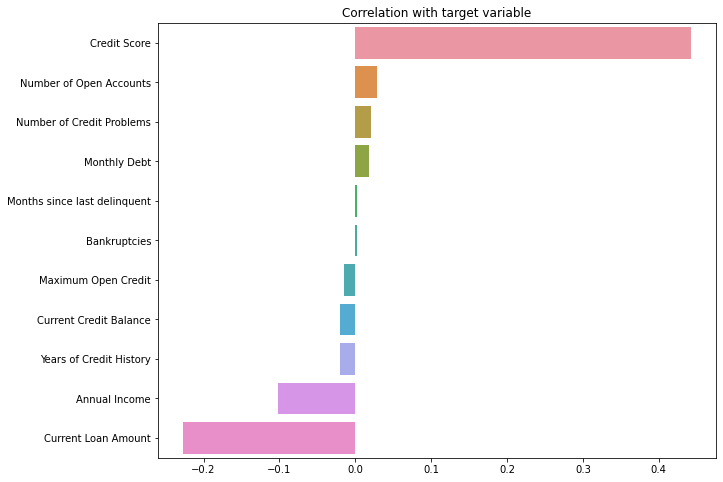

In [10]:
corr_with_target = df[NUMERIC_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [11]:
def var_target_plot(var_name, t1=None, t2=None):
    var_target_0 = df.loc[df[TARGET_NAME] == 0, var_name]
    var_target_1 = df.loc[df[TARGET_NAME] == 1, var_name]
    
    if not (t1 and t2):    
        t1 = min(df[var_name])
        t2 = max(df[var_name])
    else:
        t1 = min(df.loc[(df[var_name] >= t1) & (df[var_name] <= t2), var_name])
        t2 = max(df.loc[(df[var_name] >= t1) & (df[var_name] <= t2), var_name])
    print(f'min: {t1}, max: {t2}')
    if t1 == t2:
        t1 -= 1

    bins = np.linspace(t1, t2, 50)
    plt.figure(figsize=(8,4))
    plt.hist(var_target_0, bins, density=True, alpha=0.5, label='No default')
    plt.hist(var_target_1, bins, density=True, alpha=0.5, label='Default')
    plt.legend(bbox_to_anchor=(1.2,1), loc='upper right')
    plt.show()
    
    
def distribution_diff(var_name):
    var_target_0 = df.loc[df[TARGET_NAME] == 0, var_name].value_counts(normalize=True)
    var_target_1 = df.loc[df[TARGET_NAME] == 1, var_name].value_counts(normalize=True)
    return var_target_0 - var_target_1

#### 1. Credit Score

min: 585.0, max: 7510.0


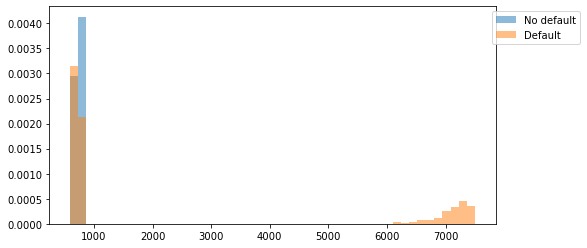

In [12]:
var_name = 'Credit Score'
var_target_plot(var_name)

Признак Credit Score нужно анализировать в двух диапазонах 580-1000 и 1000-7510

min: 585.0, max: 751.0


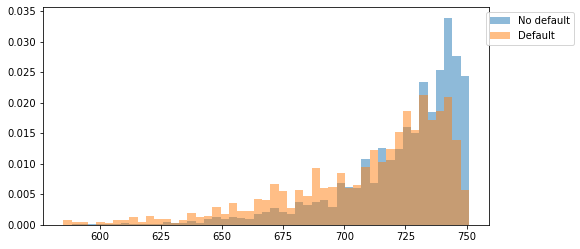

In [13]:
var_target_plot(var_name, 585, 1000)

* При Credit Score до 710 наблюдается высокая плотность дефолтов
* При Credit Score 710 - 730 уровень дефолтов снижается
* В диапазоне Credit Score 730-742 ситуация преломляется в полььзу бездефолтных кредитов 
* В диапазоне Credit Score 742-754 уровень дефолтов самый низкий 

min: 6060.0, max: 7510.0


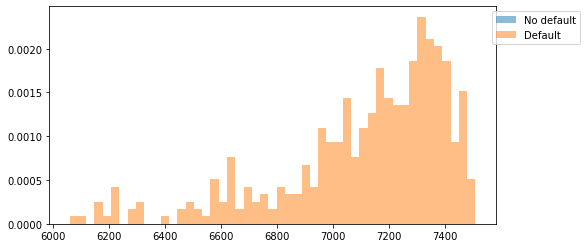

In [14]:
var_target_plot(var_name, 1000, 7510)

При значениях Credit Score выше 6000 целевая переменная равна 1 (100% дефолт)

In [15]:
obs = np.array([[10, 10, 20], [50, 20, 20]])
g, p, dof, expctd = ss.chi2_contingency(obs)
p

0.0018009437526656726

In [16]:
var_target_0 = df.loc[df[TARGET_NAME] == 0, var_name]
var_target_1 = df.loc[df[TARGET_NAME] == 1, var_name]

#### 2. Current Loan Amount

min: 11242.0, max: 99999999.0


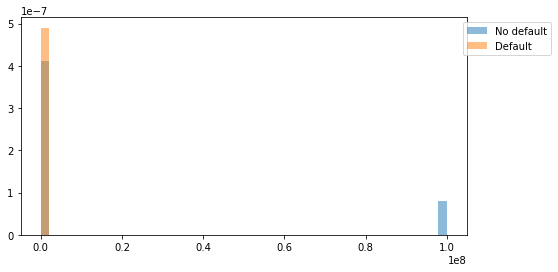

In [17]:
var_name = 'Current Loan Amount'
var_target_plot(var_name)

Признак Current Loan Amount нужно анализировать в двух диапазонах до 1 млн. и выше 1 млн.

min: 11242.0, max: 789030.0


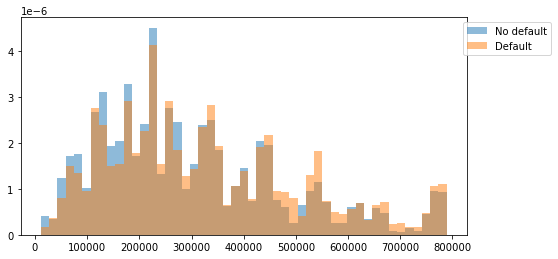

In [18]:
var_target_plot(var_name,  11242.0, 1e+06)

В диапазоне до 790 тыс неблюдается следующая картина:
* Самый низкий уровень дефолтов при значении Current Loan Amount до 250 тыс.
* Средний уровень при значении признака 250-500 тыс.
* Самый высокий уровень дефолтов в диапазоне 500-800тыс.

min: 99999999.0, max: 99999999.0


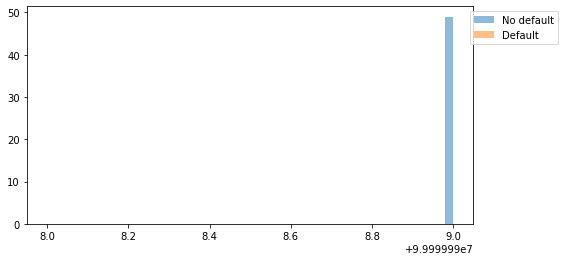

In [19]:
var_target_plot('Current Loan Amount', 1e+06, 99999999)

В диапазоне выше 1 млн. есть единственное значение Current Loan Amount: 99999999. Оно соответствует полному отсутствию дефолтов.

#### 3. Annual Income

min: 164597.0, max: 10149344.0


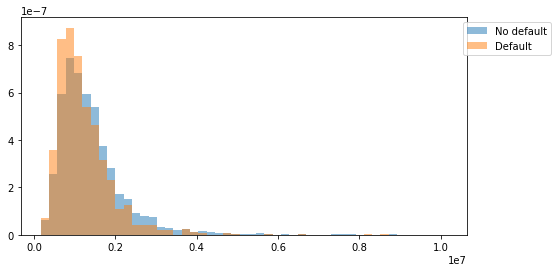

In [20]:
var_name = 'Annual Income'
var_target_plot(var_name)

Рассмотрим 2 диапазона Annual Income: до 3 млн. и выше 3 млн.

min: 164597.0, max: 2997497.0


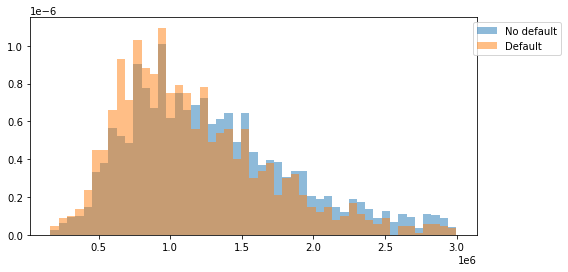

In [21]:
var_target_plot(var_name,  164597, 3e+06)

* При Annual Income до 1.1 млн наблюдается самая высокая вероятность дефолта
* В диапазоне 1.1-3 млн. вероятность дефолта заметно снижается.

min: 3009201.0, max: 10149344.0


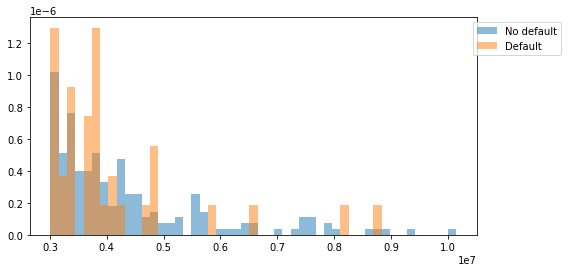

In [22]:
var_target_plot(var_name,  3e+06, 10149344)

Далее выделяются диапазоны 3-5 млн. и выше 5 млн

#### 4. Number of Open Accounts

min: 2.0, max: 43.0


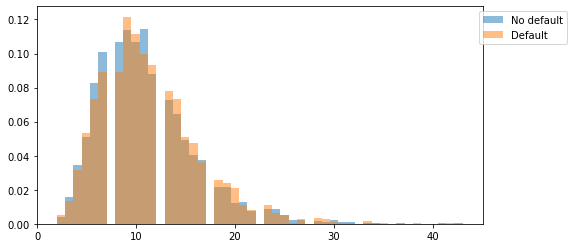

In [23]:
var_target_plot('Number of Open Accounts')

* При Number of Open Accounts до 8 включительно, наблюдается самый низкий уровень дефолтов
* В диапазоне 9-12 ситуация ухудшается
* При Number of Open Accounts выше 12 уровеньь дефолтов самый высокий 

#### 5. Monthly Debt

min: 0.0, max: 136679.0


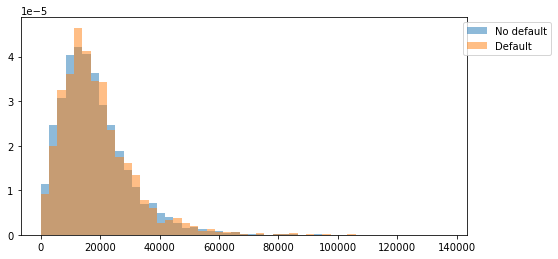

In [24]:
var_target_plot('Monthly Debt')

* При Monthly Debt ниже 6 тыс. уровень дефолтов самый низкий
* Далее ситуация постепенно ухудшается в диапазонах 6-10, выше 10 тыс.

#### 6. Years of Credit History

min: 4.0, max: 57.7


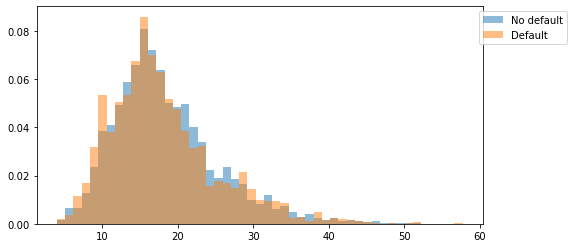

In [25]:
var_target_plot('Years of Credit History')

* Самый высокий уровень дефолтов наблюдается при Years of Credit History до 10
* Далее он постепенно снижается в диапазонах 10-13, выше 13-28, а после 28 снова возрастает

#### 7. Current Credit Balance

min: 0.0, max: 6506797.0


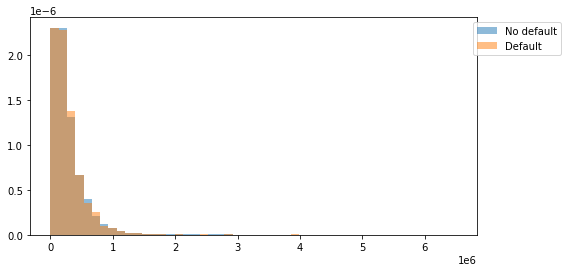

In [26]:
var_name = 'Current Credit Balance'
var_target_plot(var_name)

Рассмотрим диапазоны Current Credit Balance до 500 тыс и выше

min: 19.0, max: 499852.0


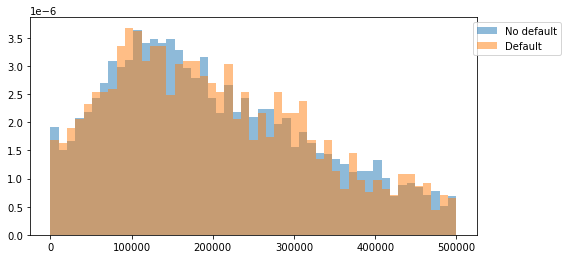

In [27]:
var_target_plot(var_name, 0.1, 5e+05)

* В диапазоне  до 500 тыс Current Credit Balance ведет себя нестабильно, какие-то тенденции заметит сложно.
* Нужно проанализировать, поможет ли укрупннение диапазонв до 110 тыс, 110-170, 170-320, 320-500 тыс, выявлению како-то функциональной зависимости.

min: 500232.0, max: 6506797.0


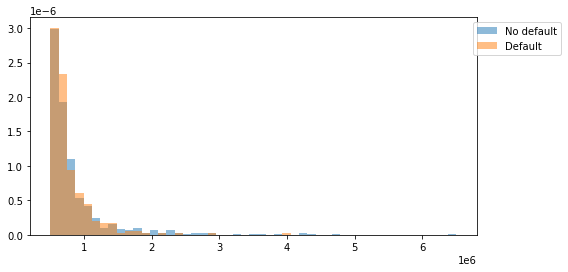

In [28]:
var_target_plot(var_name, 5e+05, 6506797)

* Диапазон выше 500 тыс. также нужно анализировать дополнительно

#### 8. Maximum Open Credit

min: 0.0, max: 1304726170.0


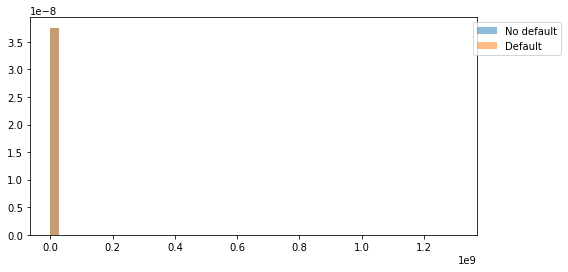

In [29]:
var_name = 'Maximum Open Credit'
var_target_plot(var_name)

Рассмотрим 2 диапазона Maximum Open Credit: до 7 млн и выше

min: 4334.0, max: 6890070.0


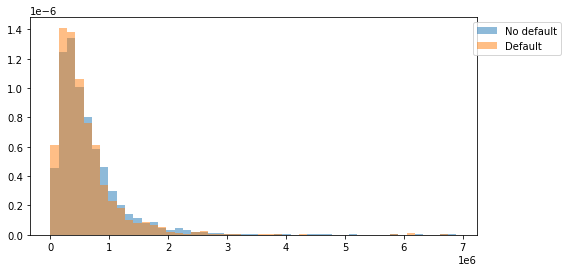

In [30]:
var_target_plot(var_name, 0.1, 7e+06)

Отдельно рассмотрим диапазон до 600 тыс.

min: 4334.0, max: 599984.0


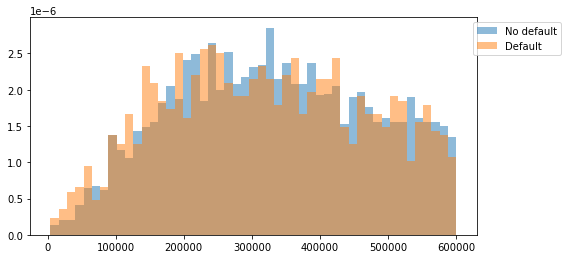

In [31]:
var_target_plot(var_name, 0.1, 6e+05)

* Самый высокий уровень дефолтов наблюдается при Maximum Open Credit до 170 тыс.
* В диапазонах 170-600, 600-800 тыс., 800 тыс.-7 млн. уровень дефолтов постепенно снижается

min: 7204516.0, max: 1304726170.0


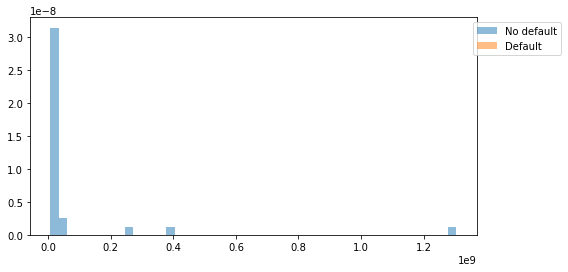

In [32]:
var_target_plot(var_name, 7e+06, 1304726170)

В диапазоне выше 7 млн. дефолтов не наблюдается

#### 9. Months since last delinquent

min: 1.0, max: 92.0


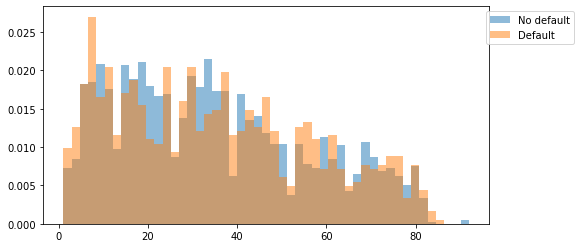

In [33]:
var_target_plot('Months since last delinquent', 0.1, 100)

Разобъем Months since last delinquent на 2 диапазона: до 36 и после.

min: 1.0, max: 36.0


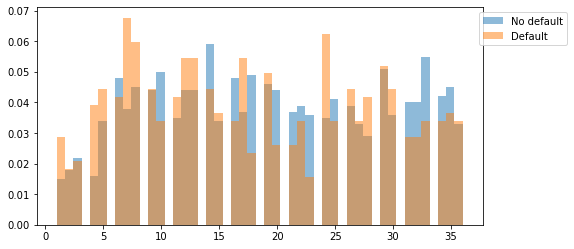

In [34]:
var_target_plot('Months since last delinquent', 1, 36)

* Уровень дефолтов Months since last delinquent до 13 месяцев выше чем в диапазоне 13-24.
* В диапазоне 25-30 наблюдается рост дефолтов, а в 31-36 - снижение.

min: 36.0, max: 92.0


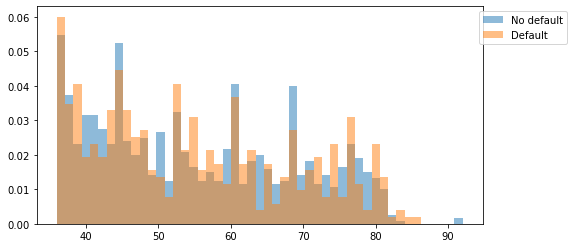

In [35]:
var_target_plot('Months since last delinquent', 36, 92)

* После 36 месяцев уровень дефолтов немного снижается.

#### 10. Number of Credit Problems

min: 0.0, max: 7.0


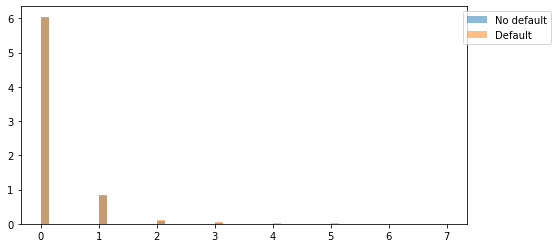

In [36]:
var_name = 'Number of Credit Problems'
var_target_plot(var_name)

In [37]:
distribution_diff(var_name)

0.0    0.004963
1.0    0.004934
2.0   -0.004480
3.0   -0.002727
4.0   -0.002283
5.0   -0.001336
6.0         NaN
7.0         NaN
Name: Number of Credit Problems, dtype: float64

Зависимости дефолтов от изменения уровней Number of Credit Problems не наблюдается. Признак не будет задействован в модели

In [38]:
NUMERIC_FEATURE_NAMES.remove(var_name)

#### 11. Bankruptcies

min: 0.0, max: 4.0


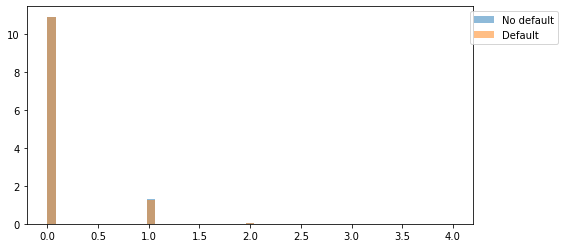

In [39]:
var_name = 'Bankruptcies'
var_target_plot(var_name)

In [40]:
distribution_diff(var_name)

0.0   -0.001126
1.0    0.002929
2.0   -0.001496
3.0   -0.000018
4.0   -0.000288
Name: Bankruptcies, dtype: float64

Зависимости дефолтов от изменения уровней Bankruptcies не наблюдается. Признак не будет задействован в модели

In [41]:
NUMERIC_FEATURE_NAMES.remove(var_name)

#### Анализ признакового пространства

**Матрица корреляций**

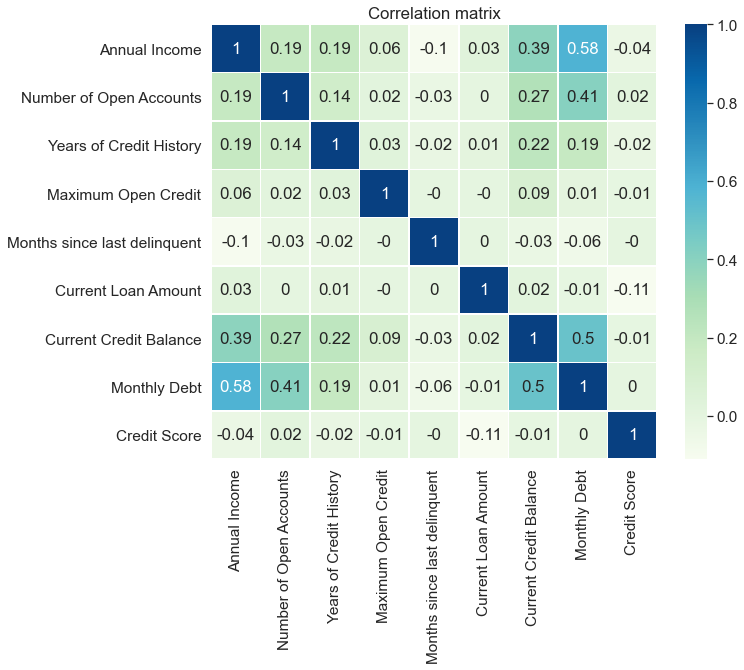

In [42]:
plt.figure(figsize = (10, 8))

sns.set(font_scale=1.4)
sns.heatmap(df[NUMERIC_FEATURE_NAMES].corr().round(2), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

#### B. Категориальные признаки

In [43]:
def category_var_target_plot(var_name, t1, t2):
    var_target_0 = df.loc[df[TARGET_NAME] == 0, var_name]
    var_target_1 = df.loc[df[TARGET_NAME] == 1, var_name]

    bins = np.linspace(0, t1, t2)
    plt.figure(figsize=(8, 4))
    plt.hist(var_target_0, bins, density=True, alpha=0.5, label='No default')
    plt.hist(var_target_1, bins, density=True, alpha=0.5, label='Default')
    plt.legend(bbox_to_anchor=(1.3,1), loc='upper right')
    plt.show()

#### 1. Term

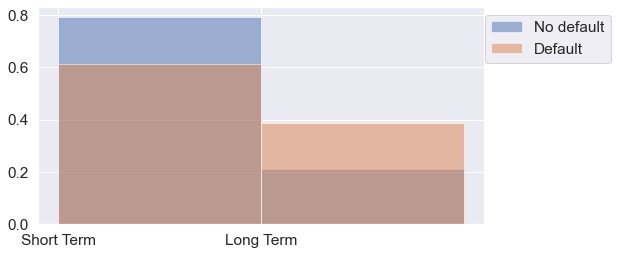

In [44]:
var_name = 'Term'
category_var_target_plot('Term', 2, 3)

In [45]:
distribution_diff(var_name)

Short Term    0.176788
Long Term    -0.176788
Name: Term, dtype: float64

Уровень дефолтов у долгосрочных кредитв существанно выше, чем у краткосрочных.

#### 2. Home Ownership

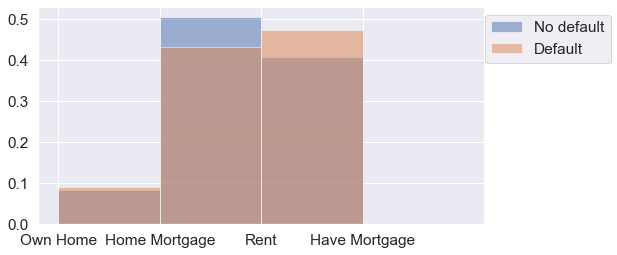

In [46]:
var_name = 'Home Ownership'
category_var_target_plot(var_name, 4, 5)

In [47]:
distribution_diff(var_name)

Have Mortgage    0.000910
Home Mortgage    0.071598
Own Home        -0.006403
Rent            -0.066104
Name: Home Ownership, dtype: float64

У признака Home Ownership уровень дефолта различается только в 2 категриях: Home Morgage и Rent. В модели будем использовать только их.
У Home Morgage уровень дефолта ниже, у Rent - выше

#### 3. Purpose

In [48]:
var_name = 'Purpose'
distribution_diff(var_name)

business loan          -0.012293
buy a car               0.002007
buy house               0.000381
debt consolidation      0.013588
educational expenses    0.001197
home improvements       0.005320
major purchase          0.001495
medical bills          -0.001316
moving                  0.000724
other                  -0.006357
renewable energy             NaN
small business         -0.004398
take a trip             0.000279
vacation                0.000167
wedding                 0.000149
Name: Purpose, dtype: float64

В признаке Purpose уровень дефолта немного различается только в 2 категриях: debt consolidation и business loan. В модели будем использовать только их.
Уровень дефолтов у business loan выше, чем у debt consolidation

#### 4. Years in current job

In [49]:
var_name = 'Years in current job'
distribution_diff(var_name)

10+ years    0.001665
2 years      0.001688
3 years      0.001295
< 1 year    -0.002065
5 years     -0.001384
1 year      -0.001612
4 years     -0.000703
6 years     -0.004146
7 years     -0.000867
8 years      0.001375
9 years      0.004753
Name: Years in current job, dtype: float64

Категории признака Years in current job практически не различаются по уровню дефолтов. В модели использовать не будем.

In [50]:
CATEGORICAL_FEATURE_NAMES.remove(var_name)

#### 5.Tax Liens

In [51]:
var_name = 'Tax Liens'
distribution_diff(var_name)

0.0    0.006752
1.0   -0.000406
2.0   -0.004314
3.0   -0.001438
4.0   -0.000863
5.0   -0.000288
6.0         NaN
7.0         NaN
Name: Tax Liens, dtype: float64

Категории признака Tax Liens практически не различаются по уровню дефолтов. В модели использовать не будем.

In [52]:
CATEGORICAL_FEATURE_NAMES.remove(var_name)

### 3.3 Пропуски данных

In [53]:
len(df) - df.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

Пропуски данных рассматриваем как отдельную категорию и заполнять не будем.

### 4. Создание групп для Weight of Evidence (WOE) 

Ввиду того, что выборка несбалансированна, будем использовать Weight of Evidence (WOE) признаков

In [54]:
def WOE_formula(a, epsilon=1e-04):
    a = a.mean()
    if a == 1.0:
        a -= epsilon
    elif a == 0:
        a += epsilon

    return np.log(a / (1 - a))

In [55]:
bin_split_numeric = {}
WOE = {}

### A. Numeric variables

In [56]:
def WOE_calc_numeric(feature, bin_split):
    feature_dict = {}
    if df[feature].isnull().sum() > 0:
        a = df.loc[df[feature].isnull(), 'Credit Default']
        print(f'n_items bin nan = {len(a)}') 
        feature_dict['nan'] = WOE_formula(a)

    for i in range(1, len(bin_split)):
        cond_1 = df[feature] >= bin_split[i - 1]
        cond_2 = df[feature] < bin_split[i]
        a = df.loc[(cond_1 & cond_2), 'Credit Default']
        print(f'n_items bin {int(bin_split[i])} = {len(a)}') 
        feature_dict[bin_split[i]] = WOE_formula(a)
        
    bin_split_numeric[feature] = bin_split
    WOE[feature] = feature_dict   

#### 1. Annual Income

In [57]:
feature = 'Annual Income'
bin_split = [0, 1.1e+06, 3e+06, 5e+06, 1e+08]
WOE_calc_numeric(feature, bin_split)
print('\nWOE per bin:')
WOE[feature]

n_items bin nan = 1557
n_items bin 1100000 = 2645
n_items bin 3000000 = 3073
n_items bin 5000000 = 181
n_items bin 100000000 = 44

WOE per bin:


{'nan': -0.664382014156811,
 1100000.0: -0.7841714040259439,
 3000000.0: -1.1878264374022938,
 5000000.0: -1.500704712297635,
 100000000.0: -2.3025850929940455}

#### 2. Number of Open Accounts

In [58]:
feature = 'Number of Open Accounts'
bin_split = [0, 9, 13, 9999] #18,
WOE_calc_numeric(feature, bin_split)
print('\nWOE per bin:')
WOE[feature]

n_items bin 9 = 2415
n_items bin 13 = 2659
n_items bin 9999 = 2426

WOE per bin:


{9: -1.0436025047360038, 13: -0.9286968564142538, 9999: -0.841024560064772}

#### 3. Years of Credit History

In [59]:
feature = 'Years of Credit History'
bin_split = [0, 10, 13, 28, 99]
WOE_calc_numeric(feature, bin_split)
print('\nWOE per bin:')
WOE[feature]

n_items bin 10 = 590
n_items bin 13 = 1037
n_items bin 28 = 5116
n_items bin 99 = 757

WOE per bin:


{10: -0.6829948090959274,
 13: -0.8801180004804297,
 28: -0.9979175364419043,
 99: -0.8104532307553416}

#### 4. Maximum Open Credit

In [60]:
feature = 'Maximum Open Credit'
bin_split = [0, 0.17e+06, 0.6e+06, 0.8e+06, 7e+06, 9e+09] 
WOE_calc_numeric(feature, bin_split)
print('\nWOE per bin:')
WOE[feature]

n_items bin 170000 = 780
n_items bin 600000 = 3834
n_items bin 800000 = 1043
n_items bin 7000000 = 1813
n_items bin 9000000000 = 30

WOE per bin:


{170000.0: -0.6758888423306645,
 600000.0: -0.8762817755745248,
 800000.0: -0.944651849495853,
 7000000.0: -1.1651789142238673,
 9000000000.0: -9.21024036697585}

#### 5. Months since last delinquent

In [61]:
feature = 'Months since last delinquent'
bin_split = [0, 13, 24, 31, 36, 999]
WOE_calc_numeric(feature, bin_split)
print('\nWOE per bin:')
WOE[feature]

n_items bin nan = 4081
n_items bin 13 = 617
n_items bin 24 = 626
n_items bin 31 = 384
n_items bin 36 = 284
n_items bin 999 = 1508

WOE per bin:


{'nan': -0.9599264632365533,
 13: -0.7645181744518642,
 24: -1.1286574670994975,
 31: -0.7884573603642702,
 36: -1.2755429968271879,
 999: -0.8485612844339757}

#### 6. Current Loan Amount

In [62]:
feature = 'Current Loan Amount'
bin_split = [0, 0.15e+06, 0.25e+06, 0.35e+06, 0.5e+06, 1e+06, 1e+08]
WOE_calc_numeric(feature, bin_split)
print('\nWOE per bin:')
WOE[feature]

n_items bin 150000 = 1341
n_items bin 250000 = 1654
n_items bin 350000 = 1400
n_items bin 500000 = 1157
n_items bin 1000000 = 1078
n_items bin 100000000 = 870

WOE per bin:


{150000.0: -0.9351592161785379,
 250000.0: -0.8536397669124878,
 350000.0: -0.747214401830221,
 500000.0: -0.664758177297259,
 1000000.0: -0.5356407928857146,
 100000000.0: -9.21024036697585}

#### 7. Current Credit Balance

In [63]:
feature = 'Current Credit Balance'
bin_split = [0, 0.11e+06, 0.17e+06, 0.32e+06, 0.5e+06, 1e+07]
WOE_calc_numeric(feature, bin_split)
print('\nWOE per bin:')
WOE[feature]

n_items bin 110000 = 1783
n_items bin 170000 = 1274
n_items bin 320000 = 2198
n_items bin 500000 = 1179
n_items bin 10000000 = 1066

WOE per bin:


{110000.0: -0.9037612022592226,
 170000.0: -1.0226003518860602,
 320000.0: -0.8743088686756385,
 500000.0: -0.9788863730533715,
 10000000.0: -0.9701064395703548}

#### 8. Monthly Debt

In [64]:
feature = 'Monthly Debt'
bin_split = [0, 0.06e+05, 0.1e+05, 1e+06]
WOE_calc_numeric(feature, bin_split)
print('\nWOE per bin:')
WOE[feature]

n_items bin 6000 = 794
n_items bin 10000 = 1052
n_items bin 1000000 = 5654

WOE per bin:


{6000.0: -1.1154760947201146,
 10000.0: -0.9996440718624063,
 1000000.0: -0.9002509061931185}

#### 9. Credit Score

In [65]:
feature = 'Credit Score'
bin_split = [0, 710, 730, 742, 755, 9999]
WOE_calc_numeric(feature, bin_split)
print('\nWOE per bin:')
WOE[feature]

n_items bin nan = 1557
n_items bin 710 = 1410
n_items bin 730 = 1377
n_items bin 742 = 1473
n_items bin 755 = 1283
n_items bin 9999 = 400

WOE per bin:


{'nan': -0.664382014156811,
 710: -0.7773392717802932,
 730: -1.1665852722543157,
 742: -1.485107755783986,
 755: -2.091776499837787,
 9999: 9.21024036697596}

### B. Categorical variables

In [66]:
def calc_a(sub_category):    
    cond = df[feature] == sub_category[0]
    for j in range(1, len(sub_category)):
        cond |= (df[feature] == sub_category[j])        
    a = df.loc[cond, 'Credit Default']    
    return a

def WOE_calc(feature, category_list):
    feature_dict = {}
    if df[feature].isnull().sum() > 0:
        a = df.loc[df[feature].isnull(), 'Credit Default']
        print(f'n_items category nan = {len(a)}')

        feature_dict['nan'] = WOE_formula(a)
    
    for i in range(len(category_list)):
        if isinstance(category_list[i], list):
            a = calc_a(category_list[i])
        else:
            a = df.loc[df[feature] == category_list[i], 'Credit Default']
        print(f'{len(a)}\t{category_list[i]}')
        WOE_ = WOE_formula(a)       
        
        if isinstance(category_list[i], list):
            for category in category_list[i]:
                feature_dict[category] = WOE_
        else:
            feature_dict[category_list[i]] = WOE_
            
    bin_split_categorical[feature] = category_list
    WOE[feature] = feature_dict    

In [67]:
bin_split_categorical = {}

#### 1. Home Ownership

In [68]:
feature = 'Home Ownership'
df[feature].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

Категории 'Own Home' и 'Have Mortgage' не влияют на уровень дефолта по кредитам, поэтому использовать их не будем

In [69]:
category_list = ['Home Mortgage', 'Rent']
WOE_calc(feature, category_list)
print('\nWOE per category:')
WOE[feature]

3637	Home Mortgage
3204	Rent

WOE per category:


{'Home Mortgage': -1.0887383741091161, 'Rent': -0.7859162935645262}

#### 2. Purpose

In [70]:
feature = 'Purpose'
df[feature].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

Будем использовать только категории, различающиеся по уровню дефолтов: debt consolidation и business loan

In [71]:
category_list = ['debt consolidation', 'business loan']
WOE_calc(feature, category_list)
print('\nWOE per category:')
WOE[feature]

5944	debt consolidation
129	business loan

WOE per category:


{'debt consolidation': -0.9530901363384262,
 'business loan': -0.2967319079716989}

#### 3. Term

In [72]:
feature = 'Term'
df[feature].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [73]:
category_list = ['Short Term', 'Long Term']
WOE_calc(feature, category_list)
print('\nWOE per category:')
WOE[feature]

5556	Short Term
1944	Long Term

WOE per category:


{'Short Term': -1.1889804856067696, 'Long Term': -0.3237870770938973}

### 5. Feature Engineering

In [74]:
class FeatureGenerator:
    def __init__(self, bin_split_numeric, bin_split_categorical, 
                 NUMERIC_FEATURE_NAMES, CATEGORICAL_FEATURE_NAMES):
        self.bin_split_numeric = bin_split_numeric
        self.bin_split_categorical = bin_split_categorical
        self.NUMERIC_FEATURE_NAMES = NUMERIC_FEATURE_NAMES
        self.CATEGORICAL_FEATURE_NAMES = CATEGORICAL_FEATURE_NAMES
        
        
    def WOE_formula(self, a, epsilon=1e-04):
        a = a.mean()
        if a == 1.0:
            a -= epsilon
        elif a == 0:
            a += epsilon
            
        return np.log(a / (1 - a))
    
        
    def WOE_calc_numeric(self, feature):
        feature_dict = {}
        if df[feature].isnull().sum() > 0:
            a = df.loc[df[feature].isnull(), 'Credit Default']
            feature_dict['nan'] = self.WOE_formula(a)

        for i in range(1, len(self.bin_split_numeric[feature])):
            cond_1 = df[feature] >= self.bin_split_numeric[feature][i - 1]
            cond_2 = df[feature] < self.bin_split_numeric[feature][i]
            a = df.loc[(cond_1 & cond_2), 'Credit Default']            

            feature_dict[self.bin_split_numeric[feature][i]] = self.WOE_formula(a) 

        return feature_dict
    
    
    def calc_a(self, feature, sub_category):    
        cond = df[feature] == sub_category[0]
        for j in range(1, len(sub_category)):
            cond |= (df[feature] == sub_category[j]) 
            
        a = df.loc[cond, 'Credit Default']
        
        return a
    
    
    def WOE_calc_categorical(self, feature):
        feature_dict = {}
        if df[feature].isnull().sum() > 0:
            a = df.loc[df[feature].isnull(), 'Credit Default'] 
            feature_dict['nan'] = self.WOE_formula(a)

        for i in range(len(self.bin_split_categorical[feature])):
            sub_category = self.bin_split_categorical[feature][i]
            if isinstance(sub_category, list):                
                a = self.calc_a(feature, sub_category)                
            else:
                a = df.loc[df[feature] == sub_category, 'Credit Default']  
            WOE_ = self.WOE_formula(a)            

            if isinstance(sub_category, list):                
                for item in sub_category:                    
                    feature_dict[item] = WOE_
            else:
                feature_dict[sub_category] = WOE_
        
        return feature_dict 
        
    
    def fit(self, X, y=None):
        df = X.copy()
        
        if y is not None:
            df['Credit Default'] = y.values 
            
            self.WOE = {}
            for feature in self.NUMERIC_FEATURE_NAMES:
                self.WOE[feature] = self.WOE_calc_numeric(feature)
                
            for feature in self.CATEGORICAL_FEATURE_NAMES:
                self.WOE[feature] = self.WOE_calc_categorical(feature)  

    
    def transform(self, X):
        for feature in self.NUMERIC_FEATURE_NAMES:
            new_feature = feature + '_'        
            if X[feature].isnull().sum() > 0:
                X.loc[X[feature].isnull(), new_feature] = self.WOE[feature]['nan']            
            
            feature_list = self.bin_split_numeric[feature]
            for i in range(1, len(feature_list)):
                cond_1 = X[feature] >= feature_list[i - 1]
                cond_2 = X[feature] < feature_list[i]
                X.loc[(cond_1 & cond_2), new_feature] = self.WOE[feature][feature_list[i]]
        

        for feature in self.CATEGORICAL_FEATURE_NAMES:
            new_feature = feature + '_'
            if X[feature].isnull().sum() > 0:
                X.loc[X[feature].isnull(), new_feature] = self.WOE[feature]['nan']
                
            feature_list = self.WOE[feature]
            for item in feature_list:        
                X.loc[X[feature] == item, new_feature] = self.WOE[feature][item] 
       
        return X.fillna(0)

### 6. Tain_test_split

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    stratify = y,
                                                    test_size=0.2)

In [76]:
features = FeatureGenerator(bin_split_numeric, bin_split_categorical, 
                            NUMERIC_FEATURE_NAMES, CATEGORICAL_FEATURE_NAMES)

In [77]:
features.fit(X_train, y_train)
X_train = features.transform(X_train)

In [78]:
features = FeatureGenerator(bin_split_numeric, bin_split_categorical, 
                            NUMERIC_FEATURE_NAMES, CATEGORICAL_FEATURE_NAMES)
features.fit(X_train, y_train)
X_train = features.transform(X_train)
X_test = features.transform(X_test)

### 7. Балансировка классов


In [79]:
ros = RandomOverSampler()
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_train_ros))

Original dataset shape Counter({0: 4310, 1: 1690})
Resample dataset shape Counter({0: 4310, 1: 4310})


### 8. Отбор признаков

In [80]:
SELECTED_FEATURE_NAMES = ['Annual Income_', 'Number of Open Accounts_','Years of Credit History_', 
                          'Maximum Open Credit_', 'Months since last delinquent_',                          
                          'Current Loan Amount_', 'Current Credit Balance_', 
                          'Monthly Debt_', 'Credit Score_',
                          
                          'Home Ownership_', 'Purpose_', 'Term_']

### 9. Модель

In [81]:
kfold =  StratifiedKFold(n_splits=5, shuffle=True)
def cv_f1_score(model):
    f1_score_list = []
    for train_index, test_index in kfold.split(X, y):
        X_train_cv, X_test_cv = X.loc[train_index, :], X.loc[test_index, :]
        y_train_cv, y_test_cv = y[train_index], y[test_index]
        
        features = FeatureGenerator(bin_split_numeric, bin_split_categorical,
                                   NUMERIC_FEATURE_NAMES, CATEGORICAL_FEATURE_NAMES)
        features.fit(X_train_cv, y_train_cv)
        X_train_cv = features.transform(X_train_cv)
        X_test_cv = features.transform(X_test_cv)
        
        X_train_ros_cv, y_train_ros_cv = ros.fit_resample(X_train_cv, y_train_cv)

        model.fit(X_train_ros_cv[SELECTED_FEATURE_NAMES], y_train_ros_cv)

        y_train_pred_cv = model.predict(X_train_ros_cv[SELECTED_FEATURE_NAMES])
        y_test_pred_cv = model.predict(X_test_cv[SELECTED_FEATURE_NAMES])

        f1_score_list.append(f1_score(y_test_cv, y_test_pred_cv, average=None)[1])
    print(f'cross_validation_f1_score_test = {np.array(f1_score_list).mean()}\n')

In [82]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('roc_auc_score =', roc_auc_score(y_train_true, y_train_pred), '\n')
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('roc_auc_score =', roc_auc_score(y_test_true, y_test_pred), '\n')
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred)) 

#### 1. LogisticRegression

In [83]:
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train_ros[SELECTED_FEATURE_NAMES], y_train_ros)

y_train_pred = model_lr.predict(X_train_ros[SELECTED_FEATURE_NAMES])
y_test_pred = model_lr.predict(X_test[SELECTED_FEATURE_NAMES])

cv_f1_score(model_lr)
get_classification_report(y_train_ros, y_train_pred, y_test, y_test_pred)

#F1 > 0.5
# 0.5397754353598971

cross_validation_f1_score_test = 0.5397754353598971

TRAIN

              precision    recall  f1-score   support

           0       0.69      0.66      0.68      4310
           1       0.68      0.70      0.69      4310

    accuracy                           0.68      8620
   macro avg       0.68      0.68      0.68      8620
weighted avg       0.68      0.68      0.68      8620

roc_auc_score = 0.6810904872389792 

TEST

              precision    recall  f1-score   support

           0       0.85      0.67      0.75      1077
           1       0.45      0.70      0.55       423

    accuracy                           0.68      1500
   macro avg       0.65      0.68      0.65      1500
weighted avg       0.74      0.68      0.69      1500

roc_auc_score = 0.6846078876838079 

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               721  356
1               127  296


#### 2. CatBoostClassifier

In [84]:
model_cb = catb.CatBoostClassifier(n_estimators=100,                  
                                   learning_rate=0.1,
                                   silent=True, random_state=21)
model_cb.fit(X_train_ros[SELECTED_FEATURE_NAMES], y_train_ros)

y_train_pred = model_cb.predict(X_train_ros[SELECTED_FEATURE_NAMES])
y_test_pred = model_cb.predict(X_test[SELECTED_FEATURE_NAMES])

cv_f1_score(model_cb)
get_classification_report(y_train_ros, y_train_pred, y_test, y_test_pred)

#F1 > 0.5
# 0.5377963915878339

cross_validation_f1_score_test = 0.5377963915878339

TRAIN

              precision    recall  f1-score   support

           0       0.72      0.74      0.73      4310
           1       0.73      0.72      0.73      4310

    accuracy                           0.73      8620
   macro avg       0.73      0.73      0.73      8620
weighted avg       0.73      0.73      0.73      8620

roc_auc_score = 0.7279582366589327 

TEST

              precision    recall  f1-score   support

           0       0.85      0.73      0.78      1077
           1       0.49      0.66      0.56       423

    accuracy                           0.71      1500
   macro avg       0.67      0.69      0.67      1500
weighted avg       0.74      0.71      0.72      1500

roc_auc_score = 0.6947325444332497 

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               781  296
1               142  281


#### 3. RandomForestClassifier

In [85]:
model_rf = RandomForestClassifier(n_estimators=100,  
                                  max_depth=6,                                  
                                  min_samples_leaf=16,
                                  random_state=42)

model_rf.fit(X_train_ros[SELECTED_FEATURE_NAMES].fillna(0), y_train_ros)

y_train_pred = model_rf.predict(X_train_ros[SELECTED_FEATURE_NAMES])
y_test_pred = model_rf.predict(X_test[SELECTED_FEATURE_NAMES])

cv_f1_score(model_rf)
get_classification_report(y_train_ros, y_train_pred, y_test, y_test_pred)

# 0.5342401411999939

cross_validation_f1_score_test = 0.5342401411999939

TRAIN

              precision    recall  f1-score   support

           0       0.68      0.74      0.71      4310
           1       0.71      0.64      0.68      4310

    accuracy                           0.69      8620
   macro avg       0.69      0.69      0.69      8620
weighted avg       0.69      0.69      0.69      8620

roc_auc_score = 0.6912993039443156 

TEST

              precision    recall  f1-score   support

           0       0.84      0.72      0.78      1077
           1       0.48      0.65      0.55       423

    accuracy                           0.70      1500
   macro avg       0.66      0.69      0.67      1500
weighted avg       0.74      0.70      0.71      1500

roc_auc_score = 0.6881474018319866 

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               777  300
1               146  277


#### 4. AdaBoostClassifier

In [86]:
model_ab = AdaBoostClassifier(n_estimators=80, 
                              learning_rate = 0.65,
                           random_state=42)
model_ab.fit(X_train_ros[SELECTED_FEATURE_NAMES], y_train_ros)

y_train_pred = model_ab.predict(X_train_ros[SELECTED_FEATURE_NAMES])
y_test_pred = model_ab.predict(X_test[SELECTED_FEATURE_NAMES])

cv_f1_score(model_ab)
get_classification_report(y_train_ros, y_train_pred, y_test, y_test_pred)

# 0.5411680496545455

cross_validation_f1_score_test = 0.5411680496545455

TRAIN

              precision    recall  f1-score   support

           0       0.69      0.69      0.69      4310
           1       0.69      0.69      0.69      4310

    accuracy                           0.69      8620
   macro avg       0.69      0.69      0.69      8620
weighted avg       0.69      0.69      0.69      8620

roc_auc_score = 0.6885150812064965 

TEST

              precision    recall  f1-score   support

           0       0.85      0.69      0.76      1077
           1       0.47      0.69      0.56       423

    accuracy                           0.69      1500
   macro avg       0.66      0.69      0.66      1500
weighted avg       0.74      0.69      0.70      1500

roc_auc_score = 0.6895862554903626 

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               747  330
1               133  290


#### 5. VotingClassifier

In [87]:
model = VotingClassifier(estimators=[('lr', model_lr), ('cb', model_cb), ('rf', model_rf), ('ab', model_ab)],
                          voting='soft', weights=[1, 1, 1, 2])
model = model.fit(X_train_ros[SELECTED_FEATURE_NAMES], y_train_ros)

y_train_pred = model.predict(X_train_ros[SELECTED_FEATURE_NAMES])
y_test_pred = model.predict(X_test[SELECTED_FEATURE_NAMES])

cv_f1_score(model)
get_classification_report(y_train_ros, y_train_pred, y_test, y_test_pred)

# 0.5443021209265644

cross_validation_f1_score_test = 0.5443021209265644

TRAIN

              precision    recall  f1-score   support

           0       0.70      0.71      0.70      4310
           1       0.71      0.69      0.70      4310

    accuracy                           0.70      8620
   macro avg       0.70      0.70      0.70      8620
weighted avg       0.70      0.70      0.70      8620

roc_auc_score = 0.7004640371229698 

TEST

              precision    recall  f1-score   support

           0       0.85      0.70      0.77      1077
           1       0.47      0.67      0.55       423

    accuracy                           0.69      1500
   macro avg       0.66      0.69      0.66      1500
weighted avg       0.74      0.69      0.71      1500

roc_auc_score = 0.6878543629862306 

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               756  321
1               138  285


### 10. Интерпретация результатов

* Наиболее значимыми признаками являются 'Credit Score_' и 'Current Loan Amount_'.
* Значимость остальных признаков модели оценивают по-разному.
* VotingClassifier объединяет четыре модели (LogisticRegression, CatBoostClassifier, RandomForestClassifier, AdaBoostClassifier) и, как правило работает лучше каждой модели в отдельности, поэтому для финанльной модели выбран результат, сгенерированный VotingClassifier.

#### ExtraTreesClassifier

Feature ranking:
1. feature 5 (0.198001)
2. feature 8 (0.183665)
3. feature 6 (0.094243)
4. feature 4 (0.091047)
5. feature 3 (0.079775)
6. feature 2 (0.066862)
7. feature 9 (0.065852)
8. feature 1 (0.055917)
9. feature 0 (0.044947)
10. feature 7 (0.044457)
11. feature 10 (0.037866)
12. feature 11 (0.037368)


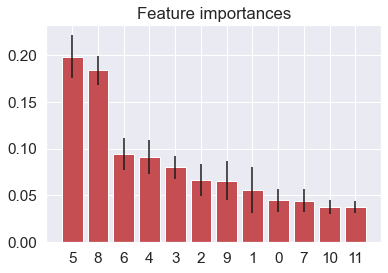

In [88]:
X = X.fillna(0)
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X_train_ros[SELECTED_FEATURE_NAMES], y_train_ros)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

f_list = []
for f in range(X_train_ros[SELECTED_FEATURE_NAMES].shape[1]):
    f_list.append(indices[f])
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_ros[SELECTED_FEATURE_NAMES].shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X_train_ros[SELECTED_FEATURE_NAMES].shape[1]])
plt.show()

In [89]:
list(X_train_ros[SELECTED_FEATURE_NAMES].columns[f_list])

['Current Loan Amount_',
 'Credit Score_',
 'Current Credit Balance_',
 'Months since last delinquent_',
 'Maximum Open Credit_',
 'Years of Credit History_',
 'Home Ownership_',
 'Number of Open Accounts_',
 'Annual Income_',
 'Monthly Debt_',
 'Purpose_',
 'Term_']

#### CatBoostClassifier

In [90]:
feature_importances = pd.DataFrame(zip(X_train_ros[SELECTED_FEATURE_NAMES].columns,
                                       model_cb.feature_importances_ / model_cb.feature_importances_.sum()), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,feature_name,importance
8,Credit Score_,0.353113
5,Current Loan Amount_,0.237006
11,Term_,0.076407
0,Annual Income_,0.058619
9,Home Ownership_,0.044120
3,Maximum Open Credit_,0.042338
4,Months since last delinquent_,0.040701
1,Number of Open Accounts_,0.038598
6,Current Credit Balance_,0.031043
2,Years of Credit History_,0.030197


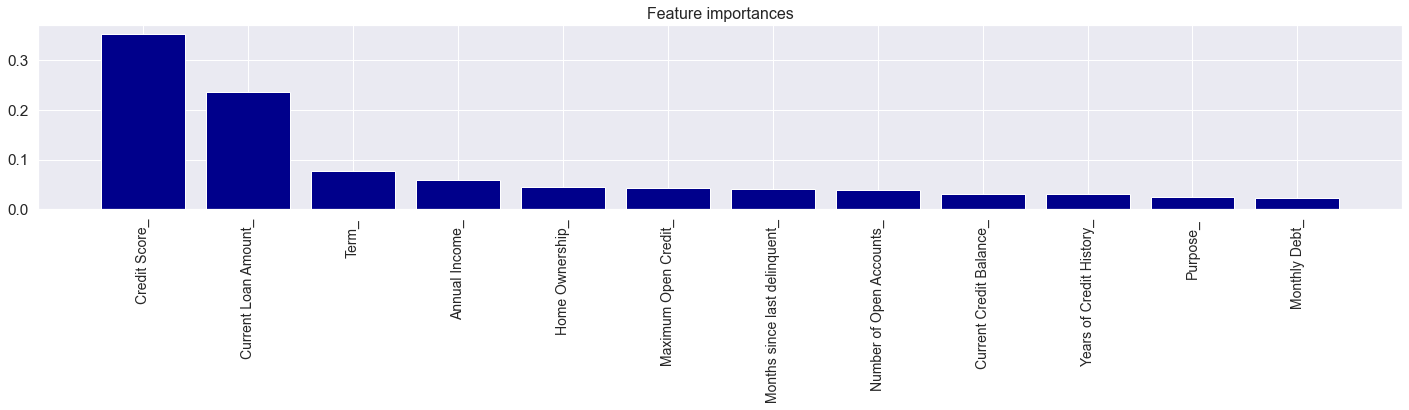

In [91]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()    
    plt.show()
    
plot_feature_importances(importances = model_cb.feature_importances_, X=X_train_ros[SELECTED_FEATURE_NAMES])

## Прогнозирование на тестовом датасете

In [92]:
features = FeatureGenerator(bin_split_numeric, bin_split_categorical,
                           NUMERIC_FEATURE_NAMES, CATEGORICAL_FEATURE_NAMES)
features.fit(X, y)
X = features.transform(X)
X_final = features.transform(X_final)

#### Балансировка классов

In [93]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_ros))

Original dataset shape Counter({0: 5387, 1: 2113})
Resample dataset shape Counter({0: 5387, 1: 5387})


#### Обучение модели на полном наборе данных

In [94]:
model = model.fit(X_ros[SELECTED_FEATURE_NAMES].fillna(0), y_ros)

#### Прогнозирование целевой переменной

In [95]:
y_pred = model.predict(X_final[SELECTED_FEATURE_NAMES].fillna(0))
y_final=pd.DataFrame(y_pred, columns=[TARGET_NAME])
y_final.to_csv(PATH + 'YKutovaya_predictions.csv')
y_final.head()

,Credit Default
0,1
1,1
2,1
3,0
4,1
